# Task 4: The Challenge

## Prepare Dataset

In [1]:
import numpy as np
import pandas as pd
import torch
import xgboost as xgb
from tqdm import tqdm

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, auc, confusion_matrix, make_scorer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from xgboost import XGBClassifier

C:\Users\post\miniconda3\envs\ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:

from operator import itemgetter

import itertools

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from numpy.linalg import norm
from scipy.optimize import differential_evolution
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, f1_score, fbeta_score
from sklearn.metrics import recall_score, precision_score, confusion_matrix

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, GroupKFold, ParameterGrid
sns.set()

In [3]:
# load datasets

df_train = pd.read_csv("task_3_training_e8da4715deef7d56_f8b7378_generic.csv", header=0)
df_test = pd.read_csv("task_4_test_dd4bd32b08b776e6_daf99ad_generic.csv", header=0)

# keep high level features (GEMS) as separate array for training

hl_train = df_train[df_train.columns[175:]]

# drop columns 175-201, since they contain the high-level features not available in the test set

df_train = df_train.drop(df_train.columns[175:], axis=1)

# drop valence and arousal as specified in the task description as well as pianist, segment and snippet column

df_train = df_train.drop(["arousal", "valence", "pianist_id", "segment_id", "snippet_id"], axis=1)
df_test_ids = df_test[["pianist_id", "segment_id", "snippet_id"]]
df_test = df_test.drop(["pianist_id", "segment_id", "snippet_id"], axis=1)

In [4]:
df_test_ids.shape

(2085, 3)

In [5]:
df_test.shape, df_train.shape

((2085, 169), (2282, 170))

In [6]:
# separate data and labels from training set

X_train = df_train[df_train.columns[:-1]]
y_train = df_train[df_train.columns[-1]]

# this adjustment is because of the XGBoost, it needs value for multiclass in 0... num of class - 1
y_train = y_train -1

## Predicting high-level features

In [7]:
# normalize data

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(df_test)

# use non-optimized xgb to predict high level features
# multioutputregressor trains one regressor for each high level feature

xgb_multi = MultiOutputRegressor(xgb.XGBRegressor(objective="reg:squarederror", random_state=42), n_jobs=-1)
xgb_multi.fit(X_train, hl_train)
hl_pred = xgb_multi.predict(X_test)

In [8]:
hl_pred

array([[2.9042423 , 3.0406234 , 1.4873655 , ..., 0.10163505, 0.04431162,
        0.03267397],
       [3.0142393 , 2.9344585 , 1.86377   , ..., 0.01307283, 0.0660662 ,
        0.34811604],
       [2.512981  , 2.1732771 , 1.7583784 , ..., 0.04756289, 0.37012482,
        0.02735191],
       ...,
       [2.9266903 , 2.861176  , 1.5889468 , ..., 0.07562069, 0.24788648,
        0.07221433],
       [2.5819573 , 2.550523  , 1.387153  , ..., 0.26977864, 0.7670786 ,
        0.04646803],
       [2.8836863 , 3.0191398 , 1.3788074 , ..., 0.29734248, 0.7923114 ,
        0.13583864]], dtype=float32)

In [9]:
# merge high level features together with test set
columns = ["gems_wonder","gems_transcendence","gems_tenderness","gems_nostalgia","gems_peacefulness","gems_power","gems_joyful_activation","gems_tension","gems_sadness","gemmes_movement","gemmes_force","gemmes_interior","gemmes_wandering","gemmes_flow","gems_wonder_binary","gems_transcendence_binary","gems_tenderness_binary","gems_nostalgia_binary","gems_peacefulness_binary","gems_power_binary","gems_joyful_activation_binary","gems_tension_binary","gems_sadness_binary","gemmes_movement_binary","gemmes_force_binary","gemmes_interior_binary","gemmes_wandering_binary","gemmes_flow_binary"]
df_test = pd.concat([df_test, pd.DataFrame(hl_pred, columns=columns)], axis=1)
df_test.to_csv("df_test_restored_hl.csv", index=False)

# df_test exploration

In [10]:
df_test

,essentia_dissonance_mean,essentia_dissonance_stdev,essentia_dynamic_complexity,essentia_loudness,essentia_onset_rate,essentia_pitch_salience_mean,essentia_pitch_salience_stdev,essentia_spectral_centroid_mean,essentia_spectral_centroid_stdev,essentia_spectral_complexity_mean,...,gems_peacefulness_binary,gems_power_binary,gems_joyful_activation_binary,gems_tension_binary,gems_sadness_binary,gemmes_movement_binary,gemmes_force_binary,gemmes_interior_binary,gemmes_wandering_binary,gemmes_flow_binary
0,0.229886,0.062064,4.818434,93184008.0,3.600000,0.614987,0.090779,1365.162964,331.913849,28.465279,...,-0.046054,1.097160,0.779082,0.078369,-0.015770,0.287028,0.351035,0.101635,0.044312,0.032674
1,0.178258,0.062866,3.003938,109259888.0,4.000000,0.564438,0.094290,1215.545288,271.362946,27.719908,...,-0.052386,0.318361,0.148020,0.431009,-0.067539,0.348549,0.613892,0.013073,0.066066,0.348116
2,0.209623,0.063750,1.983438,98162960.0,4.600000,0.553583,0.111736,1339.914185,255.108398,28.067129,...,0.200367,0.274190,0.515871,0.603049,-0.055371,0.400845,0.461815,0.047563,0.370125,0.027352
3,0.215004,0.061839,1.470698,72971816.0,3.915029,0.642106,0.092053,1143.090576,483.887421,28.758064,...,0.177475,0.520224,0.708390,0.462060,0.022678,0.570064,0.361350,0.192380,0.089040,0.096276
4,0.187017,0.072593,2.613981,80688832.0,2.600000,0.564319,0.104814,1148.319458,238.749054,28.587963,...,0.042277,0.858141,-0.026433,0.343827,0.188275,0.258797,0.455369,0.428896,0.048531,0.165239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2080,0.239235,0.048011,1.178853,50233408.0,2.516549,0.640804,0.073967,1298.177979,268.525360,27.625000,...,0.047049,0.228876,0.146252,0.363076,0.163203,0.048167,0.551620,-0.001526,0.440754,0.640478
2081,0.293661,0.060317,2.598517,178390704.0,2.400000,0.676194,0.080788,1602.075806,396.212982,29.527779,...,0.259998,0.630264,0.346204,0.758534,0.066646,0.727459,0.563753,0.123525,0.215549,0.058116
2082,0.272440,0.058219,1.851364,178757696.0,4.600000,0.681900,0.081200,1246.282837,252.229889,30.159721,...,-0.061432,0.364309,0.436263,0.261264,0.151829,0.283592,0.427677,0.075621,0.247886,0.072214
2083,0.273417,0.060010,1.930694,285332608.0,2.000000,0.708230,0.066477,1536.803711,552.418701,29.668982,...,0.085237,0.890854,0.566359,0.685380,0.134412,0.725270,0.593679,0.269779,0.767079,0.046468


<Figure size 1332x1116 with 0 Axes>

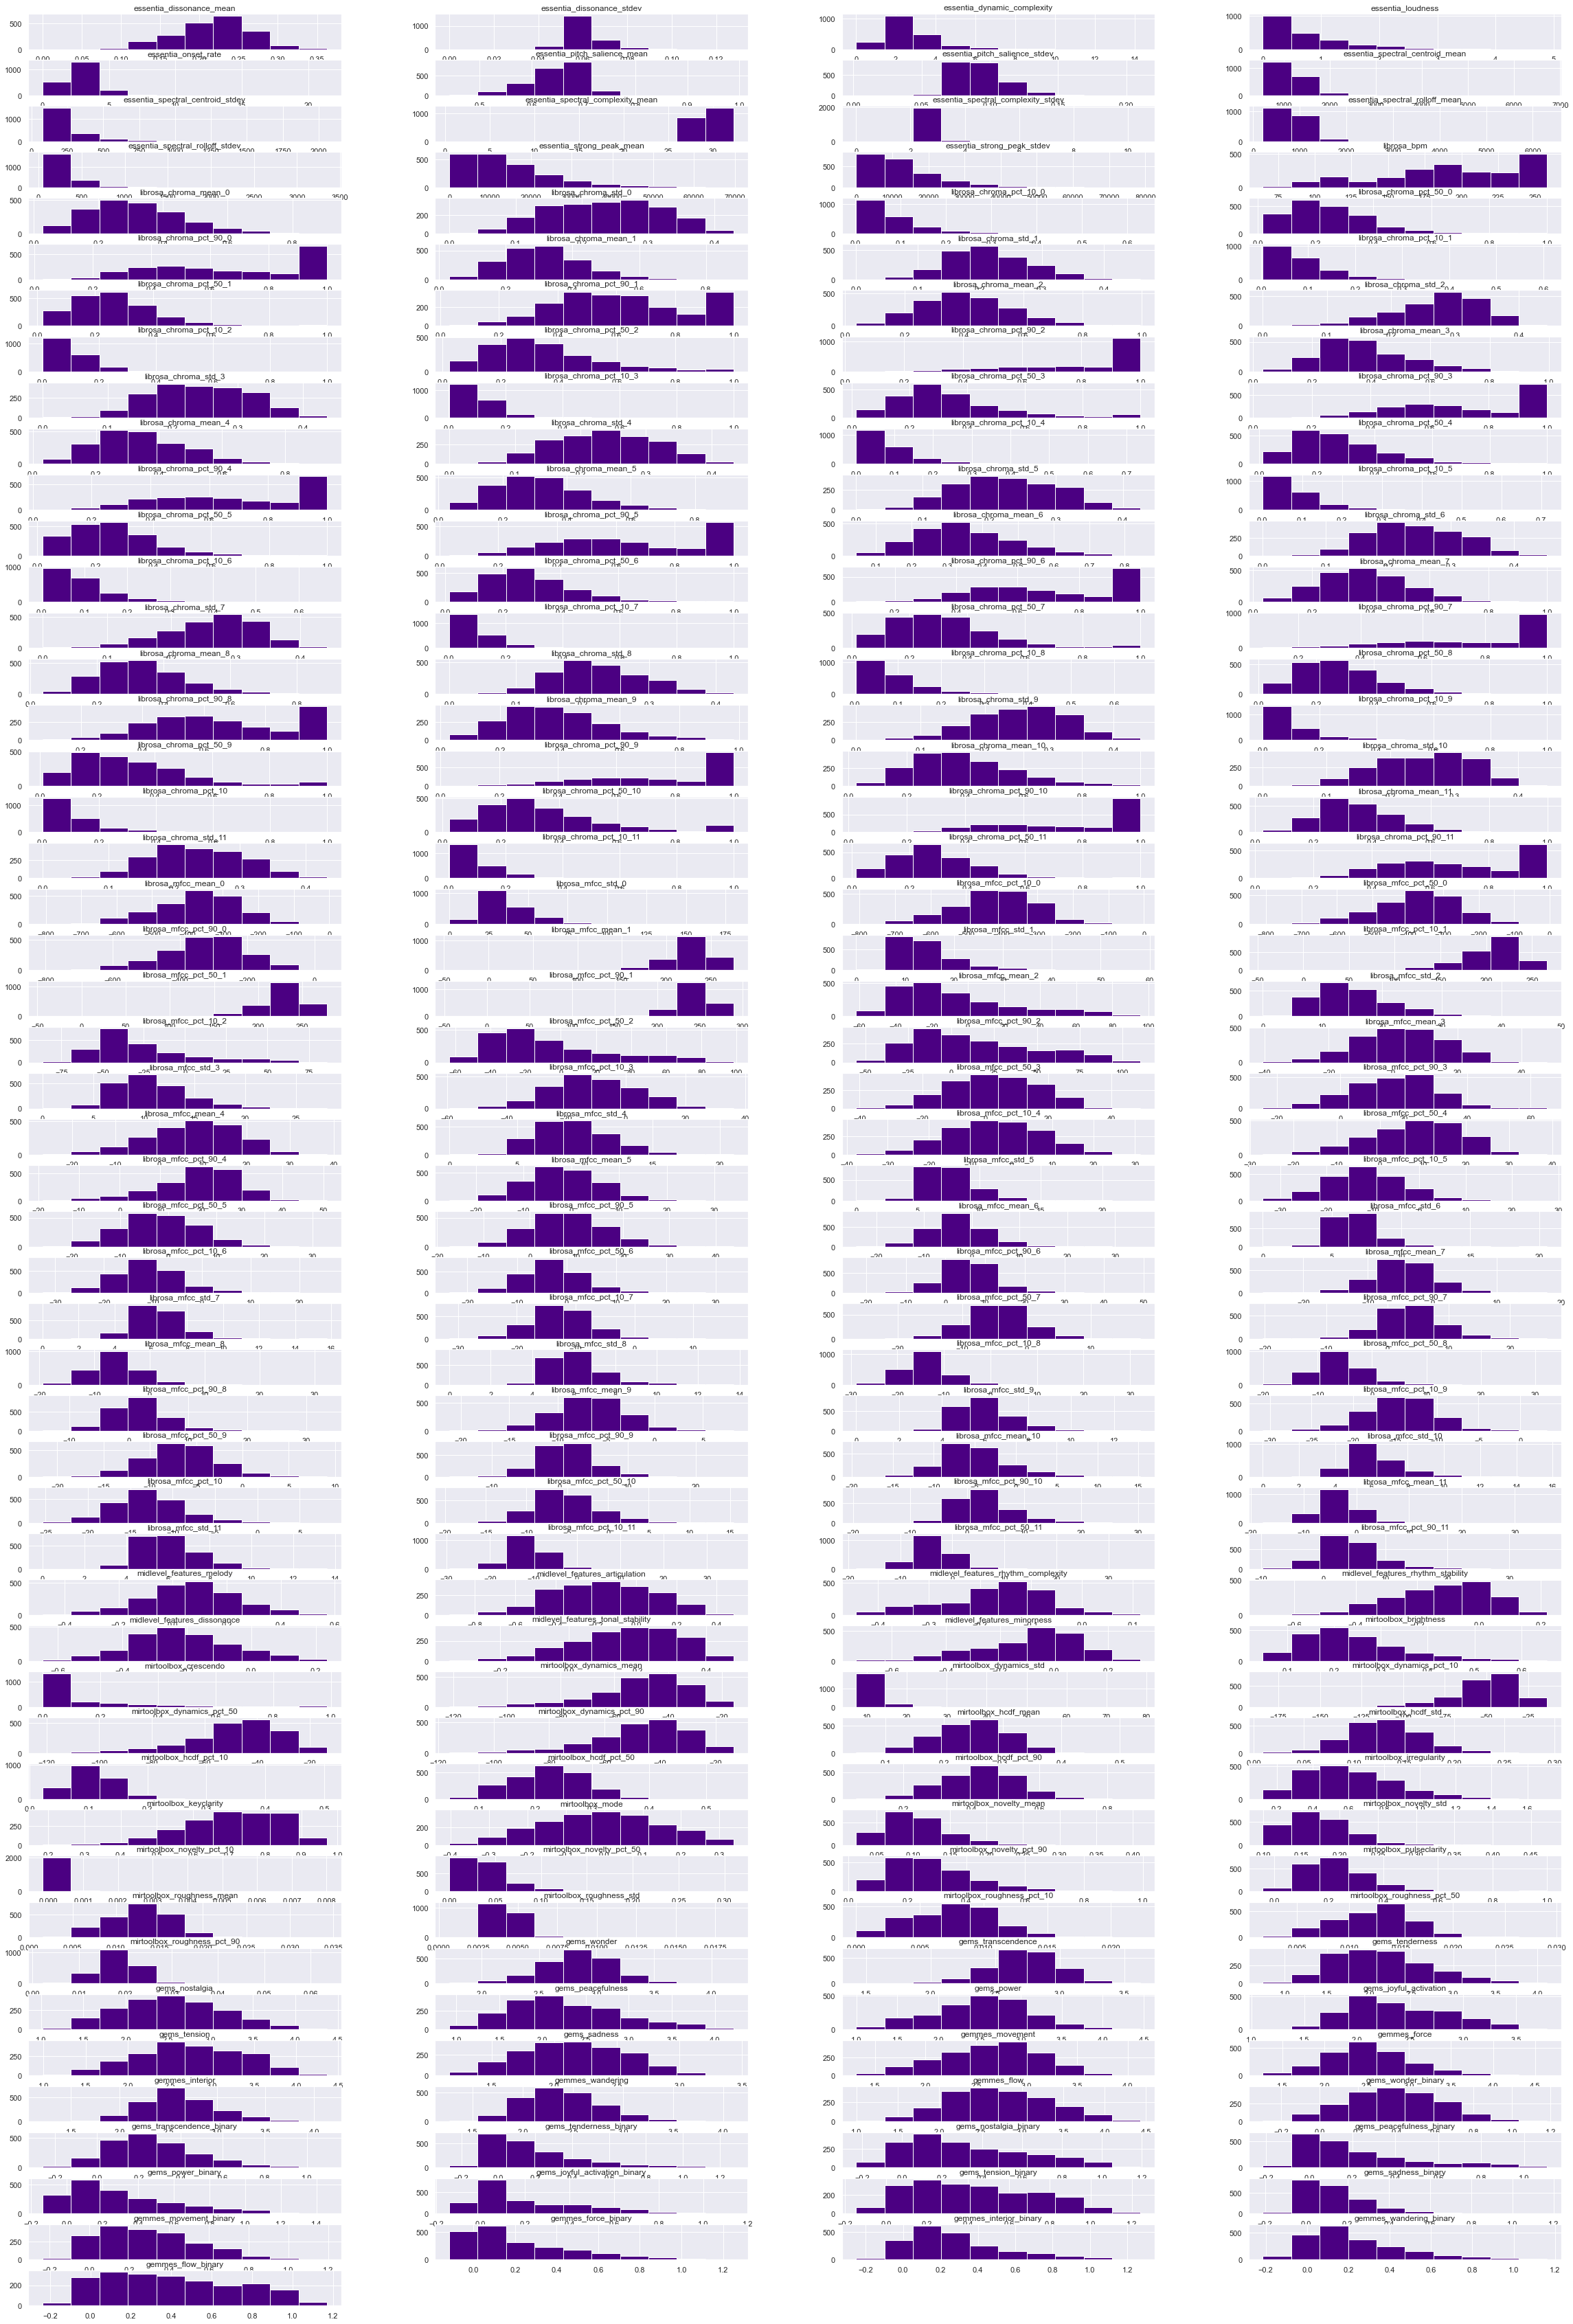

In [11]:
fig = plt.gcf()
fig.set_size_inches(18.5, 15.5)
sub_df = df_test.astype('float64')
l = sub_df.columns.shape[0]
sub_df.hist(figsize=(40,70),layout=( 57 ,4),color='indigo');

In [12]:
#calculating pearson correlations and taking only pair where significant noticed
corr = df_test.astype('float64'
                   ).corr(method='pearson')
redundant = []
for column in corr.columns:
    n_larg = corr[column].nlargest(3)
    n_smal = corr[column].nsmallest(3)
    if abs(n_larg[1])>0.75:
        print(f"{'='*60}\nFeature {column} is most correlated with\n")
        print(n_larg)
        if abs(n_smal[0])>0.75:
            print(n_smal)
    elif abs(n_smal[1])>0.75:
        print(f"{'='*60}\nFeature {column} is most correlated with\n")
        print(n_smal)
    else:
        redundant.append(column)
print(f"{'='*60}\nFollowing fetures have no significant correlations:\n{redundant}")

Feature essentia_dissonance_mean is most correlated with

essentia_dissonance_mean    1.000000
librosa_mfcc_pct_90_0       0.798239
librosa_mfcc_mean_0         0.793626
Name: essentia_dissonance_mean, dtype: float64
librosa_mfcc_mean_2     -0.827933
librosa_mfcc_pct_50_2   -0.826228
librosa_mfcc_pct_10_2   -0.808822
Name: essentia_dissonance_mean, dtype: float64
Feature essentia_loudness is most correlated with

essentia_loudness        1.000000
librosa_mfcc_mean_0      0.816831
librosa_mfcc_pct_50_0    0.815718
Name: essentia_loudness, dtype: float64
Feature essentia_spectral_centroid_mean is most correlated with

librosa_mfcc_pct_90_1   -0.787889
librosa_mfcc_mean_1     -0.779292
librosa_mfcc_pct_50_1   -0.768980
Name: essentia_spectral_centroid_mean, dtype: float64
Feature essentia_strong_peak_mean is most correlated with

essentia_strong_peak_mean     1.000000
essentia_strong_peak_stdev    0.935527
librosa_mfcc_pct_10_0         0.790019
Name: essentia_strong_peak_mean, dtype: float

In [13]:
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [14]:
get_top_abs_correlations(df_test, n=50)

librosa_mfcc_mean_0          librosa_mfcc_pct_50_0          0.997874
librosa_mfcc_mean_2          librosa_mfcc_pct_50_2          0.995912
librosa_mfcc_mean_1          librosa_mfcc_pct_50_1          0.993905
librosa_mfcc_mean_6          librosa_mfcc_pct_50_6          0.993842
mirtoolbox_roughness_mean    mirtoolbox_roughness_pct_50    0.993686
librosa_mfcc_mean_8          librosa_mfcc_pct_50_8          0.993020
librosa_mfcc_mean_4          librosa_mfcc_pct_50_4          0.992587
librosa_mfcc_mean_5          librosa_mfcc_pct_50_5          0.992577
librosa_mfcc_mean_7          librosa_mfcc_pct_50_7          0.991441
librosa_mfcc_mean_3          librosa_mfcc_pct_50_3          0.991301
librosa_mfcc_mean_11         librosa_mfcc_pct_50_11         0.991163
librosa_mfcc_mean_9          librosa_mfcc_pct_50_9          0.990392
librosa_mfcc_mean_10         librosa_mfcc_pct_50_10         0.989336
mirtoolbox_dynamics_pct_50   mirtoolbox_dynamics_pct_90     0.981914
mirtoolbox_dynamics_mean     mirto

## Predict quadrants

# There shoul be saciling but i discovered it lately. It works even without, but classifiers,
# than classiers are confused. But they work, not best.
# Never mind, do not care about it, do only what is mandatory for us. They do not check a code.

In [15]:
# reload df_train to restore high level features removed earlier and drop non usable columns and get df_test from saved file (so the notebook doesn't need to be run every time)

df_train = pd.read_csv("task_3_training_e8da4715deef7d56_f8b7378_generic.csv", header=0)
df_test = pd.read_csv("df_test_restored_hl.csv", header=0)

#There shoul be saciling but i discovered it lately. It works even without, but classifiers,
# than classiers are confused. But they work, not best.
# Never mind, do not care about it, do only what is mandatory for us. They do not check a code.
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)

# save segment_id column for GroupShuffleSplit and drop pianist, segment and snippet column
group_idx = df_train["segment_id"]

df_train = df_train.drop(["arousal", "valence", "pianist_id", "segment_id", "snippet_id"], axis=1)

In [16]:
# The last 14 columns (GEMS) are binary. So far we predicted values in range [0,1]. We round the values to match the binary type

df_test[df_test.columns[-14:]] = df_test[df_test.columns[-14:]].round(decimals=0).astype(int)

In [17]:
# prepare data and label

X = df_train.drop(["quadrant"], axis=1)
y = df_train["quadrant"]

# this adjustment is because of the XGBoost, it needs value for multiclass in 0... num of class - 1
y = y -1

In [18]:
# custom scoring function for GridSearchCV

# Labels and corresponding mood
# 1: happy
# 2: angry
# 3: sad
# 4: relaxed

def filmotion_scoring(y, y_pred):
    balance = 0
    revenue_matrix = np.array([[5,-5,-5,2],[-5,10,2,-5],[-5,2,10,-5],[2,-5,-2,5]])
    for true, pred in zip(y, y_pred):
        balance += revenue_matrix[int(true),int(pred)]
    return balance/len(y)

In [19]:
mask = np.logical_or(np.logical_or(group_idx==20, group_idx==21), group_idx==23)

# define validation set
X_valid = X.loc[mask]
y_valid = y.loc[mask]
group_idx_valid = group_idx.loc[mask]

# define training set
mask = np.invert(mask)
X_train = X.loc[mask]
y_train = y.loc[mask]
group_idx_train = group_idx.loc[mask]

In [20]:
# we will use GroupKFold which seperates our data into k folds in which the groups differ, in a way that in 
# the first fold only group 1,2 in the second fold only group 3,4 ... are listed
gkf = GroupKFold(n_splits=6)

In [21]:
# make custom scorer for grid search using previously defined scoring function
filmotion = make_scorer(filmotion_scoring)

In [22]:
def sensitivity_matric(yTest, yPred, write=True):
    c_matrix = confusion_matrix(yTest, yPred)
    tmp = 0 
    for i in range(4):
        tmp += c_matrix[i,i] / sum(c_matrix[i,:])
        if write:
            print(f'sensitivity of classier  {i}. is: {c_matrix[i,i] / sum(c_matrix[i,:])}' )
    return tmp 

In [23]:
# Getting the best parameter settings using GridSearch

#########
## KNN ##
#########

knn_params = {"n_neighbors" : [3, 5, 25, 50], "algorithm": ["auto"], "weights": ["uniform"]}

knn_model = GridSearchCV(KNeighborsClassifier(), param_grid=knn_params, cv=gkf, scoring=filmotion)
knn_model.fit(X_train, y_train, groups=group_idx_train)
knn_param = knn_model.best_params_
knn_model = knn_model.best_estimator_
print("KNN has sensitivity")
knn_prob = knn_model.predict(X_valid)
sensitivity_matric(y_valid, knn_prob)
print()


#########
## XGB ##
#########

xgb_params = {'min_child_weight': [4], 'gamma': [0], 'max_depth': [4],
             'n_estimators': [800]}

xgb_model = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='merror'), param_grid=xgb_params,
                         cv=gkf)
xgb_model.fit(X_train, y_train, groups=group_idx_train)
xgb_param = xgb_model.best_params_
xgb_model = xgb_model.best_estimator_

print("XGBoost has sensitivity")
xgb_prob = xgb_model.predict(X_valid)
sensitivity_matric(y_valid, xgb_prob)
print()
########
## RF ##
########

rf_params = { 
    'n_estimators': [200],
    'max_features': ['auto'],
    'max_depth' : [4,],
    'criterion' :['gini']
}

rf_model = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_params, cv=gkf, scoring=filmotion)
rf_model.fit(X_train, y_train, groups=group_idx_train)
rf_param = rf_model.best_params_
rf_model = rf_model.best_estimator_
print("RandomForest has sensitivity")
rf_prob = rf_model.predict(X_valid)
sensitivity_matric(y_valid, rf_prob)
print()

#########################
## Logistic Regression ##
#########################

log_reg_param = {"penalty": ['l2'], 'C': [1], "dual":[True]}
reg_model = GridSearchCV(LogisticRegression(solver='liblinear', max_iter=8000), param_grid=log_reg_param, cv=gkf, scoring=filmotion)
reg_model.fit(X_train, y_train, groups=group_idx_train)
reg_param = reg_model.best_params_
reg_model = reg_model.best_estimator_
print("LogisticRegression has sensitivity")
reg_prob = reg_model.predict(X_valid)
sensitivity_matric(y_valid, reg_prob)
print()

KNN has sensitivity
sensitivity of classier  0. is: 0.19642857142857142
sensitivity of classier  1. is: 0.36
sensitivity of classier  2. is: 0.19672131147540983
sensitivity of classier  3. is: 0.55



C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be

XGBoost has sensitivity
sensitivity of classier  0. is: 0.3392857142857143
sensitivity of classier  1. is: 0.58
sensitivity of classier  2. is: 0.2786885245901639
sensitivity of classier  3. is: 0.6375

RandomForest has sensitivity
sensitivity of classier  0. is: 0.05357142857142857
sensitivity of classier  1. is: 0.56
sensitivity of classier  2. is: 0.29508196721311475
sensitivity of classier  3. is: 0.575



C:\Users\post\miniconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\post\miniconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\post\miniconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\post\miniconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\post\miniconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\post\miniconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Li

LogisticRegression has sensitivity
sensitivity of classier  0. is: 0.0
sensitivity of classier  1. is: 0.22
sensitivity of classier  2. is: 0.3114754098360656
sensitivity of classier  3. is: 0.4



C:\Users\post\miniconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [24]:
print("LogisiticRegression has param:", reg_param)
print("KNerest has param:", knn_param)
print("DecisionTreeClassifier has param:", rf_param)
print("XGBClassifier has param:", xgb_param)


LogisiticRegression has param: {'C': 1, 'dual': True, 'penalty': 'l2'}
KNerest has param: {'algorithm': 'auto', 'n_neighbors': 50, 'weights': 'uniform'}
DecisionTreeClassifier has param: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200}
XGBClassifier has param: {'gamma': 0, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 800}


In [25]:
reg_param["solver"] = 'liblinear'
xgb_param["use_label_encoder"] = False
xgb_param["objective"] = "multi:softmax"
xgb_param["num_class"] = "4"

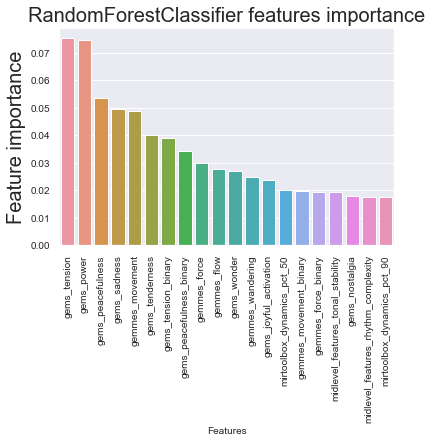

In [26]:


importance_dataset = pd.DataFrame({'Features': X.columns, 'Feature importance': rf_model.feature_importances_})
importance_dataset = importance_dataset.sort_values(by=['Feature importance'],ascending=False).reset_index(drop=True)
importance_dataset = importance_dataset[:20]
plt.title('RandomForestClassifier features importance', size=20)
ax = sns.barplot(x="Features", y="Feature importance", data=importance_dataset)

ax.set_xlabel("Features",fontsize=10)
ax.tick_params(axis='x', labelsize=10, rotation=90)
ax.set_ylabel("Feature importance",fontsize=20)
ax.tick_params(axis='y', labelsize=10, rotation=0)



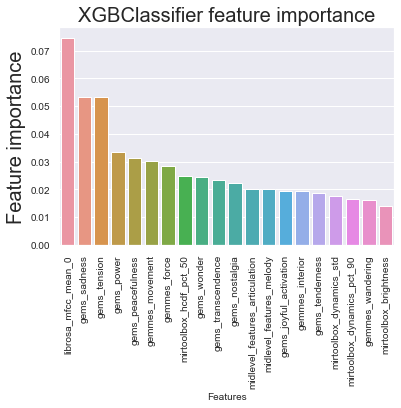

In [27]:


importance_dataset = pd.DataFrame({'Features': X.columns, 'Feature importance': xgb_model.feature_importances_})
importance_dataset = importance_dataset.sort_values(by=['Feature importance'],ascending=False).reset_index(drop=True)
importance_dataset = importance_dataset[:20]
plt.title('XGBClassifier feature importance', size=20)
ax = sns.barplot(x="Features", y="Feature importance", data=importance_dataset)

ax.set_xlabel("Features",fontsize=10)
ax.tick_params(axis='x', labelsize=10, rotation=90)
ax.set_ylabel("Feature importance",fontsize=20)
ax.tick_params(axis='y', labelsize=10, rotation=0)



False    146
True      51
Name: Feature importance, dtype: int64


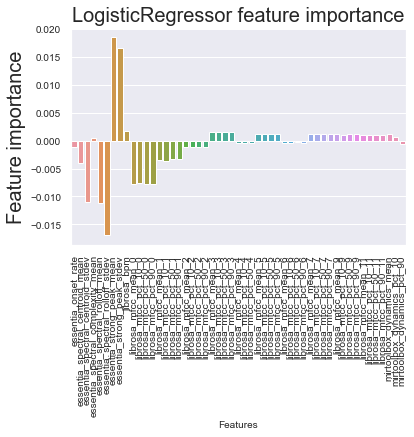

In [28]:


importance = reg_model.coef_[0]
columns = X.columns

im_df = pd.DataFrame({"Feature importance": importance, "Features": columns })

print((im_df["Feature importance"].abs() > 0.0003).value_counts())
im_df = im_df[im_df["Feature importance"].abs() > 0.0003]
plt.title('LogisticRegressor feature importance', size=20)
ax = sns.barplot(x="Features", y="Feature importance", data=im_df)

ax.set_xlabel("Features",fontsize=10)
ax.tick_params(axis='x', labelsize=10, rotation=90)
ax.set_ylabel("Feature importance",fontsize=20)
ax.tick_params(axis='y', labelsize=10, rotation=0)





The ensemble works similar to gradient descend. It tries to find the global optimum for coefficients. So we want to find the best weight for each model, that gives us the best result by summing the result of multiplying weights and model prediction.


In [29]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, weights, testX):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = np.array(yhats)
    # weighted sum across ensemble members
    summed = np.tensordot(yhats, weights, axes=((0),(0)))
    return summed.round()

# # evaluate a specific number of members in an ensemble
def evaluate_ensemble(members, weights, testX, testy):
    # make prediction
    yhat = ensemble_predictions(members, weights, testX)
    # calculate AUC
   
    
    return sensitivity_matric(testy, yhat, write=False)


# normalize a vector to have unit norm
def normalize(weights):
    # calculate l1 vector norm
    result = norm(weights, 1)
    # check for a vector of all zeros
    if result == 0.0:
        return weights
    # return normalized vector (unit norm)
    return weights / result

# loss function for optimization process, designed to be minimized
def loss_function(weights, members, testX, testy):
    # normalize weights
    normalized = normalize(weights)
    # calculate error rate
    return 1.0 - evaluate_ensemble(members, normalized, testX, testy)


In [30]:
testX = X_valid
testy = y_valid

members = [reg_model, knn_model, rf_model, xgb_model]

for i in range(len(members)):
    test_prob = members[i].predict(testX)
   
    print('Model %d: %.3f' % (i+1, accuracy_score(testy, test_prob)))
    
# evaluate averaging ensemble (equal weights)
weights = [1.0/len(members) for _ in range(len(members))]
score = evaluate_ensemble(members, weights, testX, testy)


print('Equal Weights Score: %.3f' % score)
# define bounds on each weight
bound_w = [(0.0, 1.0)  for _ in range(len(members))]
# arguments to the loss function
search_arg = (members, testX, testy)
# global optimization of ensemble weights

result = differential_evolution(loss_function, bound_w, search_arg, maxiter=300, tol=1e-7)
# get the chosen weights
weights = normalize(result['x'])
print('Optimized Weights: %s' % weights)
# evaluate chosen weights
score = evaluate_ensemble(members, weights, testX, testy)
print('Optimized Weights AUC: %.3f' % score)


Model 1: 0.251
Model 2: 0.344
Model 3: 0.385
Model 4: 0.470
Equal Weights Score: 1.334


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be

Optimized Weights: [0.05816098 0.06893178 0.01707926 0.85582798]
Optimized Weights AUC: 1.835


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [31]:
# get the chosen weights
weights = normalize(result['x'])
print('Optimized Weights: %s' % weights)
# evaluate chosen weights



Optimized Weights: [0.05816098 0.06893178 0.01707926 0.85582798]


In [32]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
#     axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
#                          train_scores_mean + train_scores_std, alpha=0.1,
#                          color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
#     axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
#                  label="Training score")
  
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

C:\Users\post\miniconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\post\miniconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\post\miniconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\post\miniconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\post\miniconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\post\miniconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Li

<module 'matplotlib.pyplot' from 'C:\\Users\\post\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

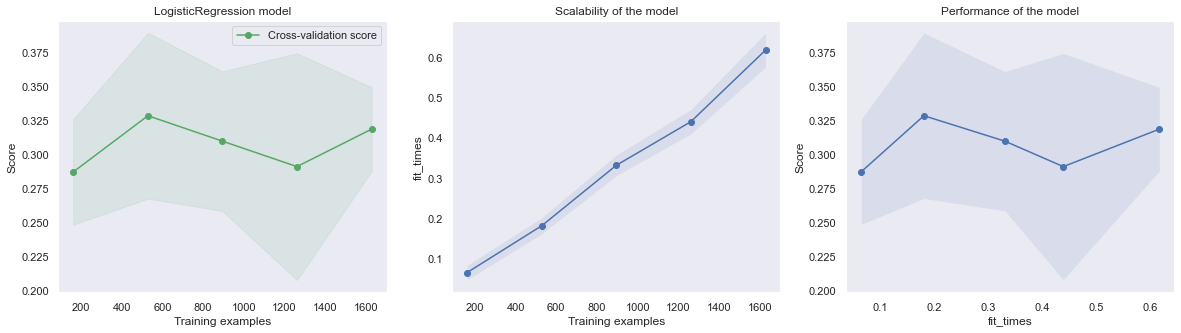

In [33]:
plot_learning_curve(LogisticRegression(**reg_param), "LogisticRegression model", X_train, y_train)

<module 'matplotlib.pyplot' from 'C:\\Users\\post\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

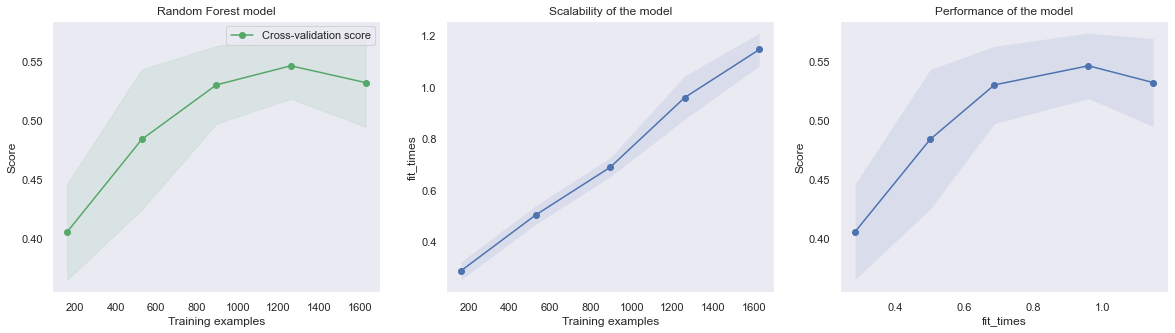

In [34]:
plot_learning_curve(RandomForestClassifier(**rf_param), "Random Forest model", X_train, y_train)

C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:35:29] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:35:30] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:35:31] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:35:34] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:35:39] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:35:49] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:35:51] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:35:53] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:35:57] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:36:04] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:36:13] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:36:15] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:36:17] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:36:21] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:36:28] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:36:38] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:36:40] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:36:42] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:36:46] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:36:52] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:37:02] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:37:03] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:37:06] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:37:11] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:37:17] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


<module 'matplotlib.pyplot' from 'C:\\Users\\post\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

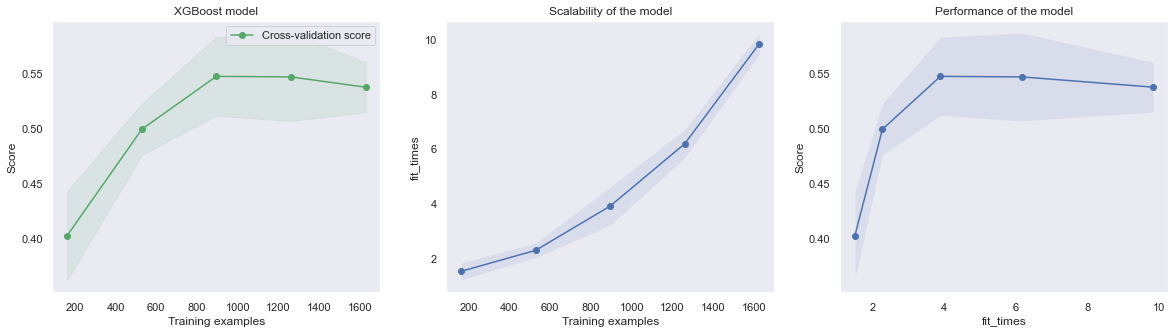

In [35]:
plot_learning_curve(XGBClassifier(**xgb_param), "XGBoost model", X_train, y_train)

<module 'matplotlib.pyplot' from 'C:\\Users\\post\\miniconda3\\envs\\ml\\lib\\site-packages\\matplotlib\\pyplot.py'>

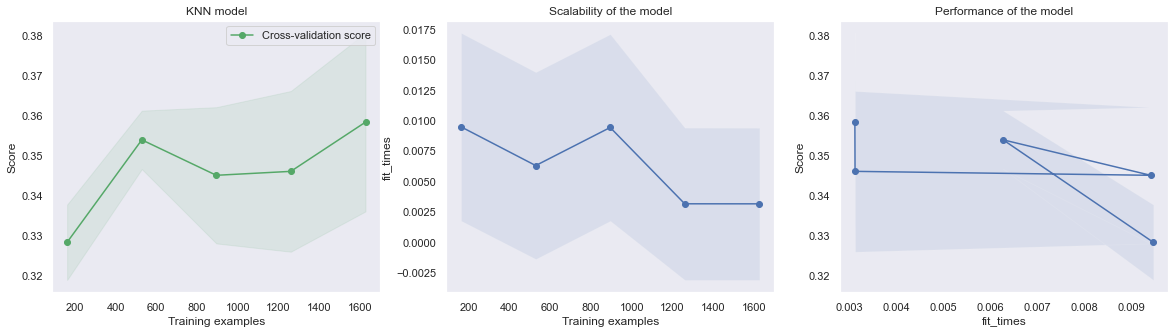

In [36]:


plot_learning_curve(KNeighborsClassifier(**knn_param), "KNN model", X_train, y_train)



In [37]:
def plot_confusion_matrix(testY, predY, key="name"):
    fig, ax = plt.subplots(figsize=(8, 8))
    cmp = ConfusionMatrixDisplay(
        confusion_matrix(testY, predY),
        display_labels=["class_1", "class_2", "class_3", "class_4"]
        )

    plt.grid(False)
    plt.title(key, size=20)
    cmp.plot(ax=ax)
    plt.show()

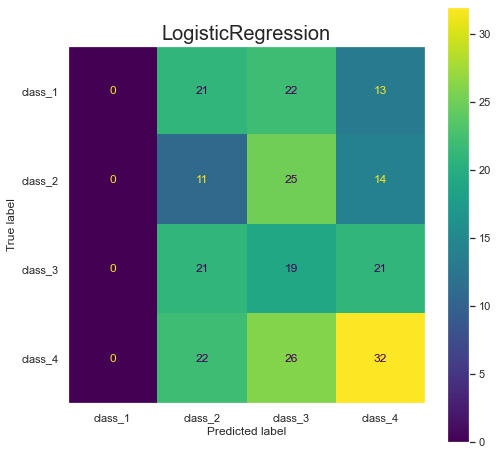

In [38]:
plot_confusion_matrix(y_valid, reg_model.predict(X_valid), key="LogisticRegression")

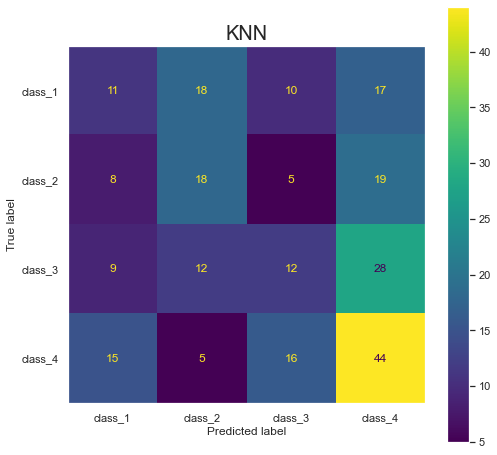

In [39]:
plot_confusion_matrix(y_valid, knn_model.predict(X_valid), key="KNN")

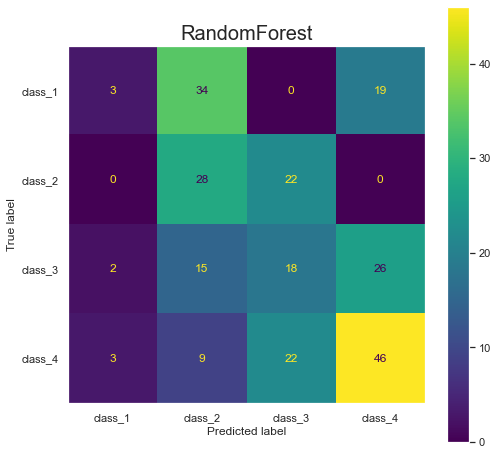

In [40]:
plot_confusion_matrix(y_valid, rf_model.predict(X_valid), key="RandomForest")

C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


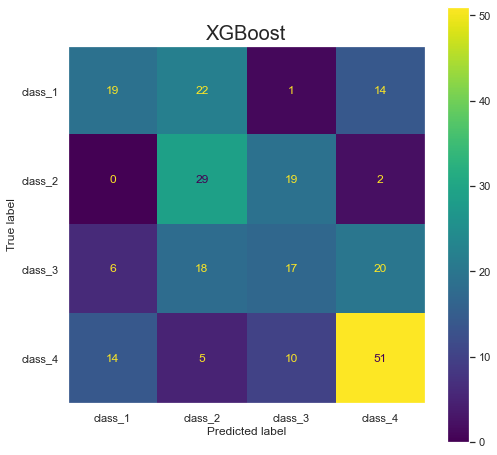

In [41]:
plot_confusion_matrix(y_valid, xgb_model.predict(X_valid), key="XGBoost")

C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


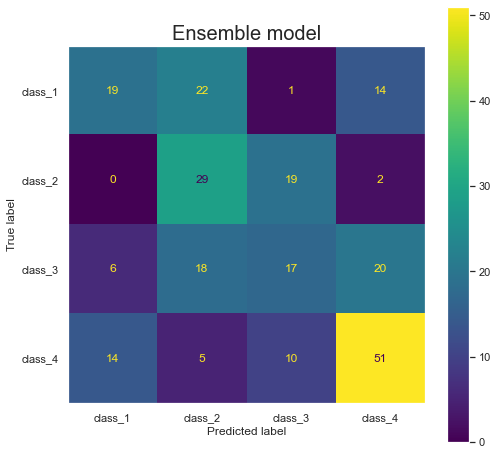

In [42]:
plot_confusion_matrix(y_valid, ensemble_predictions(members, weights, X_valid), key="Ensemble model")

# Final training

In [43]:
X_valid.shape, X_train.shape

((247, 197), (2035, 197))

In [44]:
y_valid.shape, y_train.shape

((247,), (2035,))

In [45]:
X_train_concat = pd.concat([X_valid, X_train], axis = 0)
y_train_concat = pd.concat([y_valid, y_train], axis = 0)

In [46]:
X_train_concat.shape

(2282, 197)

In [47]:
X_train

,essentia_dissonance_mean,essentia_dissonance_stdev,essentia_dynamic_complexity,essentia_loudness,essentia_onset_rate,essentia_pitch_salience_mean,essentia_pitch_salience_stdev,essentia_spectral_centroid_mean,essentia_spectral_centroid_stdev,essentia_spectral_complexity_mean,...,gems_peacefulness_binary,gems_power_binary,gems_joyful_activation_binary,gems_tension_binary,gems_sadness_binary,gemmes_movement_binary,gemmes_force_binary,gemmes_interior_binary,gemmes_wandering_binary,gemmes_flow_binary
0,0.192237,0.059404,2.040252,16079768.0,0.800000,0.677256,0.095846,1290.972900,936.912476,30.490740,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.143425,0.064204,3.138845,35489248.0,2.600000,0.514913,0.092372,1133.526733,286.292847,28.111111,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.146967,0.056205,2.019706,42130144.0,2.600000,0.560116,0.115359,1050.947632,181.327225,28.354166,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.158810,0.059129,3.567908,40922732.0,1.400000,0.596779,0.116061,1076.780151,251.776215,29.354166,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.168547,0.049648,2.329854,51921612.0,1.600000,0.556160,0.143420,1008.112183,196.336700,29.375000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2277,0.202177,0.050760,2.840705,51977460.0,1.800000,0.688834,0.090235,866.423889,133.063477,29.842592,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2278,0.174454,0.063426,5.202462,9471357.0,3.200000,0.661253,0.107627,828.768005,234.908127,30.296297,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2279,0.161152,0.074724,4.605277,7378860.5,2.600000,0.645111,0.093705,841.285645,226.538666,29.761574,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2280,0.192846,0.056795,2.563405,22641664.0,3.200000,0.680604,0.094989,716.426025,181.553772,29.881945,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [48]:
reg_model = LogisticRegression(**reg_param)
rf_model = RandomForestClassifier(**rf_param)
xgb_model = XGBClassifier(**xgb_param)
knn_model = KNeighborsClassifier(**knn_param)

reg_model.fit(X_train_concat, y_train_concat)
rf_model.fit(X_train_concat, y_train_concat)
xgb_model.fit(X_train_concat, y_train_concat)
knn_model.fit(X_train_concat, y_train_concat)

C:\Users\post\miniconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:37:36] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KNeighborsClassifier(n_neighbors=50)

In [49]:
# Final prediction
members = [reg_model, knn_model, rf_model, xgb_model]

y_test = ensemble_predictions(members, weights, df_test)

C:\Users\post\miniconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [50]:
# we did this because of xgboost, but now we need adjust it again 
y_test = y_test + 1

In [51]:
y_test = pd.Series(y_test)
y_test = pd.concat([df_test_ids ,y_test], axis=1)


In [52]:
y_test.columns = ["pianist_id", "segment_id", "snippet_id", "quadrant"]
y_test

,pianist_id,segment_id,snippet_id,quadrant
0,1,27,0,1.0
1,1,27,1,4.0
2,1,27,2,1.0
3,1,27,3,1.0
4,1,28,0,1.0
...,...,...,...,...
2080,11,60,5,1.0
2081,11,61,0,1.0
2082,11,61,1,2.0
2083,11,61,2,1.0


In [56]:
y_test_int = y_test.astype(int)

In [57]:
y_test_int.to_csv("results.csv", index=False)